
Machine Learning and Deep Learning models to predict whether a startup would be able to raise 2 million or not (probabliity of the success rate). 

The features that have been selected to train the model are based on the succes factors curated by [Task-10](https://docs.google.com/spreadsheets/d/1ZjArggdH0FsAw6LTWMAfDQJIV5e2tf53Ul6PN4ASmCQ/edit?usp=drive_web&ouid=105396664514128116511)



For the target variable, I have considered the 'Total Funding' feature from the dataset, and created a new column 'raised' where the fundings equal to  or more than 1 million are represented as '1' and '0' otherwise. 
I have selected this as a target variable by taking reference from this [article](https://techcrunch.com/2017/08/23/does-it-really-matter-how-much-your-startup-raises/?guccounter=1&guce_referrer=aHR0cHM6Ly90b3dhcmRzZGF0YXNjaWVuY2UuY29tL3ByZWRpY3Rpbmctc3RhcnR1cC1wZXJmb3JtYW5jZS11c2luZy1sb2dpc3RpYy1yZWdyZXNzaW9uLTU4MmExZTgwYjJlYg&guce_referrer_sig=AQAAAJ_eCcApkwx2p1FvKWjqVRKfYooMK6O30WWSetzFYd4WaVxYho9cDiQ2aruubwLcmhZW16yXnzJijJ6Fb1AF1yy1cH8BAXPmG87jhYLfvZRSugYjQ35geqK4CzOtXFgry1E7uOPcv8AGcQ0hvPwi-wRs2Q_gpB4lnyzAf9lPG6Cl).

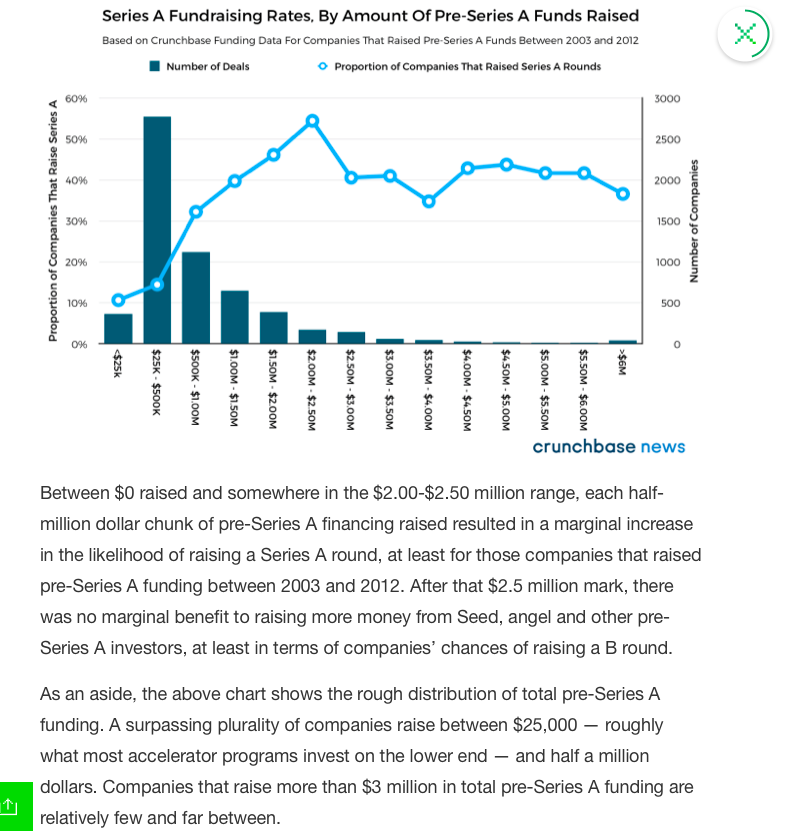
"

Although, from the above article the amount considered is 2 million, but for the model I chose 1 million as the dataset had more number of startups that raised 1 million. But even if we choose 1 million or 2 million the data becomes imbalance which requires to be treated by oversampling. 

Model with 2 million as a threshold gives better accuracy but is highly imbalanced, so wanted to ask opinion of other collaborators regarding the same. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
xgb.__version__

'0.90'

In [ ]:
df = pd.read_csv('/content/Seedstars_cleaned.csv')
df_clean = pd.read_csv('/content/Seedstars_dataset_EDA_v0.csv', sep=";")

In [ ]:
df_clean['age_today'] = df['Age today']
df_clean['age_today'].fillna(0,inplace=True)

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           4244 non-null   int64  
 1   company_id                           4244 non-null   int64  
 2   country                              4244 non-null   object 
 3   industry                             4244 non-null   object 
 4   business_stage                       4244 non-null   object 
 5   incorporated                         4244 non-null   float64
 6   incorporation_date                   4244 non-null   int64  
 7   Number of team members               4244 non-null   float64
 8   accelerator                          4244 non-null   float64
 9   amount_to_raise                      4244 non-null   int64  
 10  funding at the time of application   4244 non-null   float64
 11  number_employees              

In [ ]:
# ['country','industry','Number of team members','number_employees','business_stage','amount_to_raise', 'funding at the time of application','Funding before Seedstars', 'Total Funding', 'FUNDED',
#        'status_of_funding_AMOUNT', 'status_of_funding_STATUS',
#        'website_active','age_today']

In [ ]:
fig = px.box(df_clean, y="Total Funding")
fig.show();

In [ ]:
fig = px.box(df_clean, y="status_of_funding_AMOUNT")
fig.show();

In [ ]:
df_clean['status_of_funding_AMOUNT'].describe()

count    4.244000e+03
mean     1.578892e+04
std      8.932874e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+06
Name: status_of_funding_AMOUNT, dtype: float64

In [ ]:
df_clean['Total Funding'].describe()

count    4.244000e+03
mean     2.714219e+05
std      2.969842e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.430175e+04
max      1.255400e+08
Name: Total Funding, dtype: float64

In [ ]:
# df_clean[(df_clean['business_stage']=='Idea Stage') & (df_clean['Total Funding'] <= 74301.75)]
# df_clean[(df_clean['business_stage']=='Idea Stage') & (df_clean['Total Funding'] <= 1000000)]

In [ ]:
df_clean['age_today_years'] =  df_clean['age_today'].apply(lambda row: row//12)

In [ ]:
# classifying based on the which company raised 1 million or more funds, 'Total Funding'
# This will be represented as 1 for the startups that were successful in raising total fundings upto to 1 million funding value and 0 for those startups that could not. 

# df_clean['raised_e04'] = df_clean['Total Funding'].apply(lambda row: 1 if row>=74301.75 else 0) ---> gives poor accuracy

df_clean['raised'] = df_clean['Total Funding'].apply(lambda row: 1 if row>=1000000 else 0)

In [ ]:
df_clean['raised'].value_counts()

0    4090
1     154
Name: raised, dtype: int64

In [ ]:
df_clean['total_size'] = df_clean['number_employees'] + df_clean['Number of team members']

In [ ]:
df['revenue_1month'].fillna(0, inplace = True)
df['revenue_2month'].fillna(0, inplace = True)
df['revenue_3month'].fillna(0, inplace = True)

df_clean['revenue'] = df[['revenue_1month','revenue_2month','revenue_3month']].mean(axis =1)

In [ ]:
seedstar = df_clean.copy()
# seed.head()
seed_y = seedstar['raised']

In [ ]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    # result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 

    return result



In [ ]:
seedstar['industry'] = seedstar['industry'].replace(['Other'],'More') # to avoid duplicate features with reference to business stage

In [ ]:
print(seedstar['industry'].unique())
print(len(seedstar['industry'].unique()))


['Consumer Services' 'Travel and Transport' 'Financial Services'
 'Enterprise Services' 'HR' 'Supply chain' 'Tech'
 'Social Networking and Collaboration' 'Health / Wellness' 'Enterprise'
 'Consumer Products' 'Education' 'Education: Ed Tech' 'Retail'
 'Advertising and Marketing' 'MedTech / BioTech' 'Sports'
 'Enterprise Products' 'HighTech / NanoTech / Materials' 'More'
 'ICT / Telcom' 'Industrial / Energy / Clean Tech' 'Audio and Media'
 'Gaming / Entertainment' 'Agri: Agri Tech' 'Food and Beverage' 'Security'
 'Media' 'Automotive' 'Financial Services: Fin Tech' 'Real Estate'
 'Consumer Goods' 'Professional Services' 'Urban Development' 'Aerospace'
 'Health: Health Tech' 'Ecosystem enabler' 'Finance' 'Government']
39


In [ ]:
seedstar['industry'] = seedstar['industry'].replace(['Enterprise Services'],'Enterprise')
seedstar['industry'] = seedstar['industry'].replace(['Enterprise Products'],'Enterprise') 
seedstar['industry'] = seedstar['industry'].replace(['Financial Services'],'Finance') 
seedstar['industry'] = seedstar['industry'].replace(['Financial Services: Fin Tech'],'Finance') 
seedstar['industry'] = seedstar['industry'].replace(['Consumer Products'],'Consumer Services') 
seedstar['industry'] = seedstar['industry'].replace(['Consumer Goods'],'Consumer Services') 
seedstar['industry'] = seedstar['industry'].replace(['Education: Ed Tech'],'Education')
seedstar['industry'] = seedstar['industry'].replace(['Agri: Agri Tech'],'Agri Tech')
seedstar['industry'] = seedstar['industry'].replace(['Audio and Media'],'Media')
seedstar['industry'] = seedstar['industry'].replace(['Health / Wellness'],'Health')
seedstar['industry'] = seedstar['industry'].replace(['Health: Health Tech'],'Health') 

In [ ]:
print(seedstar['industry'].unique())
print(len(seedstar['industry'].unique()))

['Consumer Services' 'Travel and Transport' 'Finance' 'Enterprise' 'HR'
 'Supply chain' 'Tech' 'Social Networking and Collaboration' 'Health'
 'Education' 'Retail' 'Advertising and Marketing' 'MedTech / BioTech'
 'Sports' 'HighTech / NanoTech / Materials' 'More' 'ICT / Telcom'
 'Industrial / Energy / Clean Tech' 'Media' 'Gaming / Entertainment'
 'Agri Tech' 'Food and Beverage' 'Security' 'Automotive' 'Real Estate'
 'Professional Services' 'Urban Development' 'Aerospace'
 'Ecosystem enabler' 'Government']
30


In [ ]:
seedstar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 60 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           4244 non-null   int64  
 1   company_id                           4244 non-null   int64  
 2   country                              4244 non-null   object 
 3   industry                             4244 non-null   object 
 4   business_stage                       4244 non-null   object 
 5   incorporated                         4244 non-null   float64
 6   incorporation_date                   4244 non-null   int64  
 7   Number of team members               4244 non-null   float64
 8   accelerator                          4244 non-null   float64
 9   amount_to_raise                      4244 non-null   int64  
 10  funding at the time of application   4244 non-null   float64
 11  number_employees              

In [ ]:
# Performing one hot encoding on columns with text/ string values
seed_x =one_hot(one_hot(seedstar[['number_employees','age_today_years', 'revenue','industry','business_stage']],"business_stage"),"industry")

In [ ]:
seed_x.head()

,number_employees,age_today_years,revenue,Acquired,Beta Testing Stage,Dead,Development Stage,Expansion Stage,Idea Stage,Other,Pre-Revenue Stage,Revenue Stage,Advertising and Marketing,Aerospace,Agri Tech,Automotive,Consumer Services,Ecosystem enabler,Education,Enterprise,Finance,Food and Beverage,Gaming / Entertainment,Government,HR,Health,HighTech / NanoTech / Materials,ICT / Telcom,Industrial / Energy / Clean Tech,MedTech / BioTech,Media,More,Professional Services,Real Estate,Retail,Security,Social Networking and Collaboration,Sports,Supply chain,Tech,Travel and Transport,Urban Development
0,1.0,3.0,116.666667,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.0,3.0,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2.0,4.0,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9.0,4.0,0.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5.0,5.0,5000.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


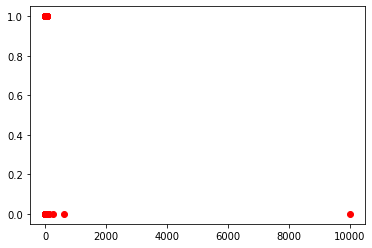

In [ ]:
plt.scatter(seed_x['number_employees'], seed_y, color='red');

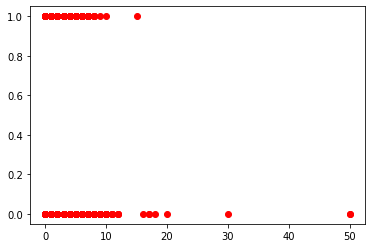

In [ ]:
plt.scatter(seed_x['age_today_years'], seed_y, color='red');

In [ ]:
# Splitting into trainig and testing dataset
seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=7)

In [ ]:
seed_x_train.columns

Index(['number_employees', 'age_today_years', 'revenue', 'Acquired',
       'Beta Testing Stage', 'Dead', 'Development Stage', 'Expansion Stage',
       'Idea Stage', 'Other', 'Pre-Revenue Stage', 'Revenue Stage',
       'Advertising and Marketing', 'Aerospace', 'Agri Tech', 'Automotive',
       'Consumer Services', 'Ecosystem enabler', 'Education', 'Enterprise',
       'Finance', 'Food and Beverage', 'Gaming / Entertainment', 'Government',
       'HR', 'Health', 'HighTech / NanoTech / Materials', 'ICT / Telcom',
       'Industrial / Energy / Clean Tech', 'MedTech / BioTech', 'Media',
       'More', 'Professional Services', 'Real Estate', 'Retail', 'Security',
       'Social Networking and Collaboration', 'Sports', 'Supply chain', 'Tech',
       'Travel and Transport', 'Urban Development'],
      dtype='object')

In [ ]:
seed_x_train = seed_x_train[['number_employees', 'age_today_years', 'revenue', 'Acquired', 'Beta Testing Stage',
       'Dead', 'Development Stage', 'Expansion Stage', 'Idea Stage',
       'Pre-Revenue Stage', 'Revenue Stage','Other', 'Advertising and Marketing',
       'Aerospace', 'Agri Tech', 'Automotive', 'Consumer Services',
       'Ecosystem enabler', 'Education', 'Enterprise', 'Finance',
       'Food and Beverage', 'Gaming / Entertainment', 'Government', 'HR',
       'Health', 'HighTech / NanoTech / Materials', 'ICT / Telcom',
       'Industrial / Energy / Clean Tech', 'MedTech / BioTech', 'Media',
       'Professional Services', 'Real Estate', 'Retail', 'Security',
       'Social Networking and Collaboration', 'Sports', 'Supply chain', 'Tech',
       'Travel and Transport', 'Urban Development','More']]

seed_x_test = seed_x_test[['number_employees', 'age_today_years','revenue', 'Acquired', 'Beta Testing Stage',
       'Dead', 'Development Stage', 'Expansion Stage', 'Idea Stage',
       'Pre-Revenue Stage', 'Revenue Stage','Other', 'Advertising and Marketing',
       'Aerospace', 'Agri Tech', 'Automotive', 'Consumer Services',
       'Ecosystem enabler', 'Education', 'Enterprise', 'Finance',
       'Food and Beverage', 'Gaming / Entertainment', 'Government', 'HR',
       'Health', 'HighTech / NanoTech / Materials', 'ICT / Telcom',
       'Industrial / Energy / Clean Tech', 'MedTech / BioTech', 'Media',
       'Professional Services', 'Real Estate', 'Retail', 'Security',
       'Social Networking and Collaboration', 'Sports', 'Supply chain', 'Tech',
       'Travel and Transport', 'Urban Development','More']]
# seed_x_train.column
seed_x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3395 entries, 1830 to 1220
Data columns (total 42 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   number_employees                     3395 non-null   float64
 1   age_today_years                      3395 non-null   float64
 2   revenue                              3395 non-null   float64
 3   Acquired                             3395 non-null   uint8  
 4   Beta Testing Stage                   3395 non-null   uint8  
 5   Dead                                 3395 non-null   uint8  
 6   Development Stage                    3395 non-null   uint8  
 7   Expansion Stage                      3395 non-null   uint8  
 8   Idea Stage                           3395 non-null   uint8  
 9   Pre-Revenue Stage                    3395 non-null   uint8  
 10  Revenue Stage                        3395 non-null   uint8  
 11  Other                      

In [ ]:
# Checking for duplicate columns
duplicate_columns = seed_x_train.columns[seed_x_train.columns.duplicated()]
duplicate_columns

Index([], dtype='object')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import model_selection


xgb = XGBClassifier()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
lr = LogisticRegression()
svm = SVC()
sgd = SGDClassifier
dtc = DecisionTreeClassifier()
gnb = GaussianNB()

In [ ]:
print('Model before evaluating')

xgb.fit(seed_x_train, seed_y_train)
xgb.predict_proba(seed_x_train)
xgb.score(seed_x_train, seed_y_train)

    
y_pred_xgb = xgb.predict(seed_x_test)
y_prob_xgb = xgb.predict_proba(seed_x_test)

    
scoring = 'roc_auc'
kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
logloss = model_selection.cross_val_score(xgb, seed_x_train, seed_y_train, cv=kfold, scoring='neg_log_loss')
results_xgb = model_selection.cross_val_score(xgb, seed_x_train, seed_y_train, cv=kfold, scoring=scoring)
    
matrix_xgb = confusion_matrix(seed_y_test, y_pred_xgb)
report_xgb = classification_report(seed_y_test, y_pred_xgb)

print('Training Set Accuracy: {}%'.format(round(xgb.score(seed_x_train, seed_y_train)*100,2)))
print('Testing Set Accuracy: {}%'.format(round(xgb.score(seed_x_test, seed_y_test)*100,2)))
# print("Log loss: %.3f (%.3f)" % (logloss.mean(), logloss.std()))
#     print('Log loss: ', logloss)
# print("AUC: %.3f (%.3f)" % (auc.mean(), auc.std()))
print('Confusion Matrix: \n', matrix_xgb)
print('Model Report: \n', report_xgb)


Model before evaluating
Training Set Accuracy: 96.38%
Testing Set Accuracy: 96.7%
Confusion Matrix: 
 [[821   1]
 [ 27   0]]
Model Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       822
           1       0.00      0.00      0.00        27

    accuracy                           0.97       849
   macro avg       0.48      0.50      0.49       849
weighted avg       0.94      0.97      0.95       849



In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# seed_x_train = scaler.fit_transform(seed_x_train)
# seed_x_test = scaler.transform(seed_x_test)
# seed_x_train

from sklearn.preprocessing import MinMaxScaler      # As data shows no distribution, I chose Normalsation.
scaler = MinMaxScaler()
train_normalized = scaler.fit_transform(seed_x_train)
seed_x_train = scaler.inverse_transform(train_normalized)

test_normalized = scaler.fit_transform(seed_x_test)
seed_x_test = scaler.inverse_transform(test_normalized)

In [ ]:
import imblearn
print(imblearn.__version__)

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

0.4.3


In [ ]:
# Performing over sampling to solve the problem of imbalanced data.

over = SMOTE(sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5) ---------> gives poor results

In [ ]:
seed_x_train, seed_y_train = over.fit_resample(seed_x_train, seed_y_train)
seed_x_test, seed_y_test = over.fit_resample(seed_x_test, seed_y_test)

## Machine Learning Models

In [ ]:
def model_result(x_train, x_test, y_train, y_test, model_name, model):
    model.fit(x_train, y_train)
    model.predict_proba(x_train)
    model.score(x_train, y_train)

    result = model.fit(x_train, y_train)
    result.predict(x_test)
    
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    
    
    
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    logloss = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_log_loss')
    auc = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc')
    
    
    matrix = confusion_matrix(y_test, y_pred)
    
    report = classification_report(y_test, y_pred)
    
    # print result
    print('\n\n')
    print('{}: '.format(model_name))
    print('Training Set Accuracy: {}%'.format(round(model.score(x_train, y_train)*100,2)))
    print('Testing Set Accuracy: {}%'.format(round(model.score(x_test, y_test)*100,2)))
    print("Log loss: %.3f (%.3f)" % (logloss.mean(), logloss.std()))
#     print('Log loss: ', logloss)
    print("AUC: %.3f (%.3f)" % (auc.mean(), auc.std()))
    print('Confusion Matrix: \n', matrix)
    print('Model Report: \n', report)
    print('\n')
    

In [ ]:
models = {'XGBoost': xgb, 'Random Forest Classifier': rfc, 'KNeighbours Classifier': knn, 'Logisitic Regression': lr, 'Decsion Tree Classifier': dtc, 'Gaussian Naive Bayes': gnb}

for key, val in models.items():
    model_result(seed_x_train, seed_x_test, seed_y_train, seed_y_test, key, val);




XGBoost: 
Training Set Accuracy: 96.05%
Testing Set Accuracy: 95.02%
Log loss: -0.160 (0.025)
AUC: 0.893 (0.041)
Confusion Matrix: 
 [[822   0]
 [ 45  37]]
Model Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       822
           1       1.00      0.45      0.62        82

    accuracy                           0.95       904
   macro avg       0.97      0.73      0.80       904
weighted avg       0.95      0.95      0.94       904






Random Forest Classifier: 
Training Set Accuracy: 99.64%
Testing Set Accuracy: 94.69%
Log loss: -0.295 (0.102)
AUC: 0.900 (0.033)
Confusion Matrix: 
 [[820   2]
 [ 46  36]]
Model Report: 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       822
           1       0.95      0.44      0.60        82

    accuracy                           0.95       904
   macro avg       0.95      0.72      0.79       904
weighted avg       0.95      0.9

In [ ]:
import pickle

xgb.save_model('model.bst')
# with open('model.bst', 'wb') as model_file:
#     pickle.dump(xgb, model_file)

In [ ]:
    #Support Vector Machine
    
    svm.fit(seed_x_train, seed_y_train)
    # svm.predict_proba(seed_x_train)
    svm.score(seed_x_train, seed_y_train)

    result = svm.fit(seed_x_train, seed_y_train)
    result.predict(seed_x_test)
    
    y_pred = svm.predict(seed_x_test)
    # y_prob = svm.predict_proba(seed_x_test)
    
    
    
    kfold = model_selection.KFold(n_splits=10, random_state=7, shuffle=True)
    # logloss = model_selection.cross_val_score(svm, seed_x_train, seed_y_train, cv=kfold, scoring='neg_log_loss')
    auc = model_selection.cross_val_score(svm, seed_x_train, seed_y_train, cv=kfold, scoring='roc_auc')
    
    
    matrix = confusion_matrix(seed_y_test, y_pred)
    
    report = classification_report(seed_y_test, y_pred)
    
    # print result
    print('\n\n')
    # print('{}: '.format(model_name))
    print('Training Set Accuracy: {}%'.format(round(svm.score(seed_x_train, seed_y_train)*100,2)))
    print('Testing Set Accuracy: {}%'.format(round(svm.score(seed_x_test, seed_y_test)*100,2)))
    # print("Log loss: %.3f (%.3f)" % (logloss.mean(), logloss.std()))
#     print('Log loss: ', logloss)
    print("AUC: %.3f (%.3f)" % (auc.mean(), auc.std()))
    print('Confusion Matrix: \n', matrix)
    print('Model Report: \n', report)
    print('\n')




Training Set Accuracy: 90.93%
Testing Set Accuracy: 90.93%
AUC: 0.558 (0.039)
Confusion Matrix: 
 [[822   0]
 [ 82   0]]
Model Report: 
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       822
           1       0.00      0.00      0.00        82

    accuracy                           0.91       904
   macro avg       0.45      0.50      0.48       904
weighted avg       0.83      0.91      0.87       904





## Deep Learning using Keras

In [ ]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense

# from keras import callbacks
# earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

    
x_train, x_test = seed_x_train, seed_x_test
y_train, y_test = seed_y_train, seed_y_test

# callbacks = myCallback()

model = Sequential()
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
# model fitting
history = model.fit(x_train, y_train, epochs=1000) # Increasing the epoch would give a better accuracy -----> upgrade the model in mia
print(history.epoch, history.history['accuracy'][-1]) 

Epoch 1/1000
113/113 [==============================] - 1s 1ms/step - loss: 20.4889 - accuracy: 0.4774
Epoch 2/1000
113/113 [==============================] - 0s 1ms/step - loss: 1.2241 - accuracy: 0.5564
Epoch 3/1000
113/113 [==============================] - 0s 1ms/step - loss: 1.1808 - accuracy: 0.8220
Epoch 4/1000
113/113 [==============================] - 0s 1ms/step - loss: 4.6868 - accuracy: 0.8950
Epoch 5/1000
113/113 [==============================] - 0s 1ms/step - loss: 0.9177 - accuracy: 0.9048
Epoch 6/1000
113/113 [==============================] - 0s 1ms/step - loss: 1.6729 - accuracy: 0.8985
Epoch 7/1000
113/113 [==============================] - 0s 1ms/step - loss: 1.8561 - accuracy: 0.9020
Epoch 8/1000
113/113 [==============================] - 0s 1ms/step - loss: 2.1367 - accuracy: 0.9093
Epoch 9/1000
113/113 [==============================] - 0s 1ms/step - loss: 0.5792 - accuracy: 0.8953
Epoch 10/1000
113/113 [==============================] - 0s 1ms/step - loss: 1.65

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold


# estimator = KerasClassifier(build_fn=model, epochs=100)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, seed_x_train, seed_y_train, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# max(results)


In [ ]:
from tensorflow import keras
model.save("my_model")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_model")


INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
np.testing.assert_allclose(
    model.predict(seed_x_test), reconstructed_model.predict(seed_x_test)
)

reconstructed_model.fit(seed_x_test, seed_y_test, epochs = 1000)

Epoch 1/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.8993
Epoch 2/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.6305 - accuracy: 0.8905
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.5178 - accuracy: 0.8971
Epoch 4/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.7663 - accuracy: 0.8993
Epoch 5/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.2298 - accuracy: 0.9038
Epoch 6/1000
29/29 [==============================] - 0s 1ms/step - loss: 0.8077 - accuracy: 0.8993
Epoch 7/1000
29/29 [==============================] - 0s 2ms/step - loss: 1.4173 - accuracy: 0.9027
Epoch 8/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.9347 - accuracy: 0.9049
Epoch 9/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.6255 - accuracy: 0.9015
Epoch 10/1000
29/29 [==============================] - 0s 1ms/step - loss: 1.2568 - accuracy: 0.9071

In [ ]:
tf.__version__

'2.4.1'

More references: 
[Reference 1](https://repository.tudelft.nl/islandora/object/uuid%3A1adc2972-db09-4583-b2da-05fd4e462941)
[Reference 2](https://www.abacademies.org/articles/systematic-literature-review-of-critical-success-factors-of-information-technology-startups-6638.html)
[Reference 3](https://hbr.org/1983/05/the-five-stages-of-small-business-growth)
[Reference 4](https://www.emailout.com/4-most-important-startup-growth-metrics-to-measure/)
[Reference 5](https://smallbiztrends.com/2019/03/startup-statistics-small-business.html)
[Reference 6](https://www.entrepreneur.com/article/271290)

In [ ]:
seedstar.drop('Unnamed: 0', axis =1, inplace = True)
seedstar.head()

,company_id,country,industry,business_stage,incorporated,incorporation_date,Number of team members,accelerator,amount_to_raise,funding at the time of application,number_employees,revenue_1month,revenue_2month,revenue_3month,users_1month,users_2month,users_3month,paying_users_1month,paying_users_2month,paying_users_3month,number_transactions_1month,number_transactions_2month,number_transactions_3month,burn_rate,number of competitors,role_0,gender_0,country_0,role_1,gender_1,company_logo,Funding before Seedstars,Total Funding,FUNDED,status_of_funding_AMOUNT,status_of_funding_STATUS,website_active,lat,lon,year_incorporated,year_segment,revenue_model_commission_Imputed,revenue_model_product_Imputed,revenue_model_on-demand_Imputed,revenue_model_subscription_Imputed,revenue_model_freemium_Imputed,revenue_model_advertising_Imputed,revenue_model_licensing_Imputed,customer_type - B-to-B-to-C_Imputed,customer_type - B-to-B_Imputed,customer_type - B-to-C_Imputed,customer_type - B-to-G_Imputed,percent_increase_in_revenue,percent_increase_in_users,age_today,age_today_years,raised,total_size,revenue
0,1,Uzbekistan,Consumer Services,Revenue Stage,0.0,2017,4.0,1.0,0,0.0,1.0,110.0,109.0,131.0,459.0,455.0,549.0,459.0,455.0,549.0,0.0,0.0,0.0,108.00,1.0,Founder,0.0,Uzbekistan,Project manager,0.0,1,0.0,0.0,0,0.0,FUNDED,1,41.32373,63.95281,2017,2017,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.459459,9.782609,36.0,3.0,0,5.0,116.666667
1,224,Uzbekistan,Travel and Transport,Development Stage,0.0,2017,4.0,0.0,30000,30000.0,3.0,8000.0,7500.0,15000.0,12.0,15.0,30.0,8.0,13.0,27.0,0.0,0.0,0.0,4999.99,2.0,Founder,0.0,Uzbekistan,Co-Founder,0.0,1,30000.0,30000.0,1,30000.0,FUNDED,0,41.32373,63.95281,2017,2017,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,43.744532,69.230769,43.0,3.0,0,7.0,0.000000
2,365,Uzbekistan,Finance,Beta Testing Stage,1.0,2019,1.0,1.0,3000,0.0,2.0,0.0,0.0,500.0,10000.0,11000.0,15000.0,10.0,35.0,30.0,0.0,0.0,0.0,1000.00,2.0,CEO,0.0,Uzbekistan,CEO,0.0,1,0.0,0.0,0,0.0,Closed,1,41.32373,63.95281,2019,2019,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,25000.000000,24.997500,58.0,4.0,0,3.0,0.000000
3,440,Uzbekistan,Enterprise,Revenue Stage,0.0,2017,10.0,0.0,0,0.0,9.0,1380.0,642.0,981.0,16.0,13.0,9.0,14.0,13.0,9.0,0.0,0.0,0.0,4800.00,5.0,CEO,0.0,Uzbekistan,Other,0.0,1,0.0,0.0,0,0.0,FUNDED,1,41.32373,63.95281,2017,2017,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-14.446054,-20.588235,54.0,4.0,0,19.0,0.000000
4,866,Uzbekistan,HR,Revenue Stage,1.0,2019,5.0,0.0,0,0.0,5.0,212.0,212.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4000.00,2.0,R&D,0.0,Uzbekistan,Marketing & BizDev,0.0,1,0.0,0.0,0,0.0,FUNDED,1,41.32373,63.95281,2019,2019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-49.765258,-25.000000,64.0,5.0,0,10.0,5000.000000


In [ ]:
seedstar.to_csv('seedstar_data.csv')